In [20]:
import torch
from vectorhash import build_vectorhash_architecture
from smoothing import RatSLAMSmoothing, ArgmaxSmoothing, PolynomialSmoothing, SoftmaxSmoothing
from shifts import RollShift
from data_utils import load_mnist_dataset, prepare_data
from graph_utils import plot_imgs_side_by_side
from matplotlib import pyplot as plt
device = "cuda"

In [21]:
N = 200
dataset = load_mnist_dataset()
obs, noisy_obs = prepare_data(dataset, num_imgs=N, device=device)

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [26]:
smoothings = [
    PolynomialSmoothing(k=2),
    PolynomialSmoothing(k=3),
    PolynomialSmoothing(k=4),
    SoftmaxSmoothing(T=0.1),
    SoftmaxSmoothing(T=0.03),
    SoftmaxSmoothing(T=0.01),
    ArgmaxSmoothing(),
    RatSLAMSmoothing(device=device),
]

obs_results = torch.ones(len(smoothings), N, 3, device=device)
noisy_obs_results = torch.ones(len(smoothings), N, 3, device=device)
noise_results = torch.ones(len(smoothings), 3, device=device)
noise = torch.randn(28 * 28, device=device)

for i, method in enumerate(smoothings):
    model = build_vectorhash_architecture(
        shapes=[(3, 3, 3), (4, 4, 4)],
        N_h=1200,
        input_size=28 * 28,
        initalization_method="by_sparsity",
        percent_nonzero_relu=0.2,
        device=device,
        smoothing=method,
        # smoothing=ArgmaxSmoothing(),
        shift=RollShift(),
        relu=True,
        epsilon_hs=0.01,
        epsilon_sh=0.01,
    )
    for j in range(N):
        model.hippocampal_sensory_layer.learn(
            model.scaffold.hippocampal_from_grid(model.scaffold.G[i])[0], obs[i]
        )

    for k in range(N):
        obs_certainty, noisy_obs_certainty = [
            model.scaffold.estimate_certainty(
                g=model.scaffold.denoise(
                    model.scaffold.grid_from_hippocampal(
                        model.hippocampal_sensory_layer.hippocampal_from_sensory(o)
                    )
                )[0]
            )
            for o in [obs[k], noisy_obs[k]]
        ]
        obs_results[i, k] = obs_certainty
        noisy_obs_results[i, k] = noisy_obs_certainty
    noise_certainty = model.scaffold.estimate_certainty(
        g=model.scaffold.denoise(
            model.scaffold.grid_from_hippocampal(
                model.hippocampal_sensory_layer.hippocampal_from_sensory(noise)
            )
        )[0]
    )
    noise_results[i] = noise_certainty

by_sparsity
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  1200
by_sparsity
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  1200
by_sparsity
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  1200
by_sparsity
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  1200
by_sparsity
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  1200
by_sparsity
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  1200
by_sparsity
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  1200
by_sparsity
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  1200


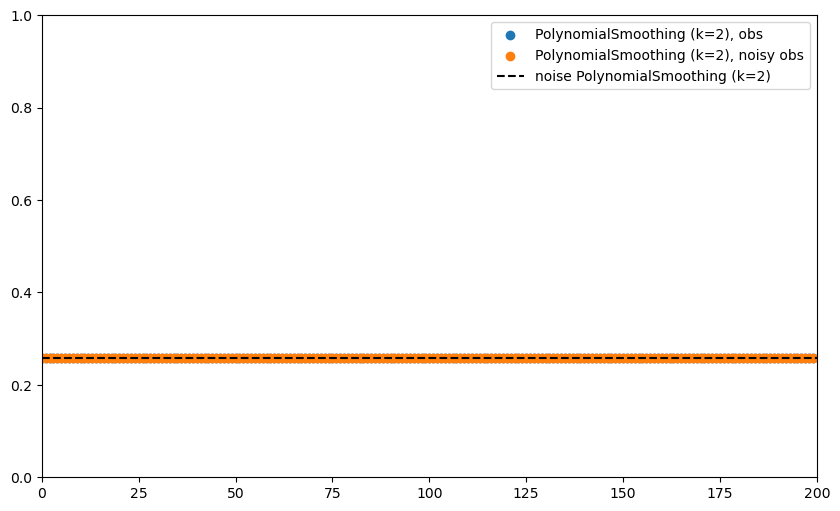

In [55]:
# obs_results = torch.ones(len(smoothings), N, 3, device=device)
# noisy_obs_results = torch.ones(len(smoothings), N, 3, device=device)

fig, ax = plt.subplots(figsize=(10, 6))

for i, method in enumerate(smoothings):
  # if not isinstance(method, SoftmaxSmoothing):
  #   continue
  # if not method.T == 0.1:
  #   continue

  # if not isinstance(method, RatSLAMSmoothing):
  #   continue

  if not isinstance(method, PolynomialSmoothing):
    continue
  if not method.k == 2:
    continue
  ax.scatter(torch.arange(0, N), obs_results[i, :, 0].cpu(), label=f"{method}, obs")
  ax.scatter(torch.arange(0, N), noisy_obs_results[i, :, 0].cpu(), label=f"{method}, noisy obs")
  ax.axhline(y=noise_results[i, 0].cpu(), label=f"noise {method}", linestyle="--", c="k")

ax.set_ylim(0, 1)
ax.set_xlim(0, N)
ax.legend()


In [14]:
h_noisy = model.hippocampal_sensory_layer.hippocampal_from_sensory(noisy_obs[k])
h_true = model.hippocampal_sensory_layer.hippocampal_from_sensory(obs[k])
h_only_noise = model.hippocampal_sensory_layer.hippocampal_from_sensory(noise)

print((h_noisy - h_true)[0][10:20])
print(h_noisy[0][10:20])

print((h_noisy - h_true)[0][10:20] / h_noisy[0][10:20])

g_noisy = model.scaffold.grid_from_hippocampal(h_noisy)
g_true = model.scaffold.grid_from_hippocampal(h_true)
g_only_noise = model.scaffold.grid_from_hippocampal(h_only_noise)

print("------------------------------------ [raw g] ------------------------------------")
print(g_noisy[:10])
print(g_true[:10])
print(g_only_noise[:10])
print("------------------------------------ [denoised g] ------------------------------------")
print(model.scaffold.denoise(g_noisy[:10]))
print(model.scaffold.denoise(g_true[:10]))
print(model.scaffold.denoise(g_only_noise[:10]))

tensor([ 0.0000,  0.0937, -0.1774, -0.0961, -0.1585, -0.1442,  0.0024,  0.0287,
         0.2558,  0.0672], device='cuda:0')
tensor([0.0000, 0.3060, 0.4095, 0.1353, 0.1171, 0.0000, 0.6730, 0.2564, 0.2558,
        0.0672], device='cuda:0')
tensor([    nan,  0.3063, -0.4332, -0.7101, -1.3535,    -inf,  0.0036,  0.1121,
         1.0000,  1.0000], device='cuda:0')
------------------------------------ [raw g] ------------------------------------
tensor([[1.9460, 1.2319, 2.5524, 1.3614, 1.6123, 1.2212, 1.6492, 1.6390, 1.5425,
         1.8631, 2.0980, 1.5283, 1.5260, 2.2694, 1.6006, 1.5324, 1.1480, 1.5033,
         1.9039, 1.5437, 1.4639, 1.8569, 1.5505, 1.5191, 1.3221, 1.8283, 1.7102,
         0.7495, 0.6629, 0.9956, 0.5462, 0.6536, 0.6179, 0.6787, 0.6069, 0.7368,
         0.5931, 0.6401, 0.6894, 0.7159, 0.9377, 0.5181, 0.7801, 0.6423, 0.5214,
         0.6377, 0.6074, 0.5770, 0.7868, 0.6908, 0.6118, 0.6263, 0.6571, 0.8890,
         0.8637, 0.6425, 0.6328, 0.6648, 0.7308, 0.7007, 0.5848, 0.891